# Hey Kaggler! 

This is part 2 of my eda-baseline exploration of the intracranial hemorrhage detection competition. It covers the implementation of preprocessing and data loading as well as the modelling part. **Just jump into it!** :-)  

<img src="https://cdn.pixabay.com/photo/2016/11/29/09/49/blond-1868815_1280.jpg" width="600px">

If you like to more about dicom, go back to the first part: https://www.kaggle.com/allunia/rsna-ih-detection-eda

## Table of contents

1. [Prepare to start](#prepare)
2. [Building up the bruteforce model](#baseline)
    * [Image preprocessing](#preprocessor)
    * [Custom Dataloader](#dataloader)
    * [Preparing the dataframe](#dataframeprep)
    * [Exploring train and test images](#traintestdiff)
    * [Building up the brutforce model](#buildbruteforce)
    * [Speeding up & dealing with class imbalance](#speedup1)
    * [Validation strategy](#validation)
    * [Let it run! :-)](#letitrun)
3. [Building up the any-subtype network](#anysubtype)
    * [The custom loss](#customloss)
    * [A two output layer network](#twooutputs)

## Updates

A lot of stuff is going on at the moment! Probably in a few days I will post an update what has changed. ;-)

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Prepare to start <a class="anchor" id="prepare"></a>

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pydicom

from os import listdir

from skimage.transform import resize
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split, StratifiedKFold

from keras.applications import ResNet50, VGG16
from keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout
from keras.initializers import glorot_normal, he_normal
from keras.regularizers import l2
from keras.models import Model, load_model
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam


from tensorflow.nn import sigmoid_cross_entropy_with_logits
import tensorflow as tf

listdir("../input/")

Using TensorFlow backend.


['keras-pretrained-models', 'rsna-intracranial-hemorrhage-detection']

In [3]:
#listdir("../input/rsna-ih-detection-baseline-models")

## Settings

In [4]:
train_brute_force = False
train_anysubtype_network = False

In [5]:
MODELOUTPUT_PATH_BRUTE_FORCE = "bruteforce_best_model.hdf5"
MODELOUTPUT_PATH_ANYSUBTYPE = "anysubtype_best_model.hdf5"
brute_force_model_input = "../input/rsna-ih-detection-baseline-models/_bruteforce_best_model.hdf5"
brute_force_losses_path = "../input/rsna-ih-detection-baseline-models/brute_force_losses.csv"
any_subtype_model_input = "../input/rsna-ih-detection-baseline-models/anysubtype_best_model.hdf5"

# Building up the baseline <a class="anchor" id="baseline"></a>

Ok, enough about dicom! ;-) 

## Image Preprocessing <a class="anchor" id="preprocessor"></a>

Ok, before we can build up a deep learning model we need to setup our dataloader and image preprocessor. I decided to use Keras as I feel most familiar with it when it comes to custom losses and in this case this could be of great benefit. Originally I wanted to use Keras ImageDataGenerator but as we have to do some preprocessing for our dicom images I like to write custom methods instead and use the [imaug](https://imgaug.readthedocs.io/en/latest/) package. My workflow is as follows:

1. Read the dicom dataset of an raw dicom image
2. Focus on a specific hounsfield window. This way we can get rid of information in the image we don't need. This could include signals from the CT-tube, towels or perhaps also some bones or further tissue we are not interested in. 
3. We need to make sure that all images have the same width and height. So far I haven't seen another shape than 512x512 but we don't know if this could change! In addition we need to make sure that the shape of the image is what is expected by our model.

In [6]:
def rescale_pixelarray(dataset):
    image = dataset.pixel_array
    rescaled_image = image * dataset.RescaleSlope + dataset.RescaleIntercept
    rescaled_image[rescaled_image < -1024] = -1024
    return rescaled_image

def set_manual_window(hu_image, min_value, max_value):
    hu_image[hu_image < min_value] = min_value
    hu_image[hu_image > max_value] = min_value #max_value
    return hu_image

class Preprocessor:    
    
    def __init__(self, path, backbone, hu_min_value, hu_max_value, augment=False):
        self.path = path
        self.backbone = backbone
        self.nn_input_shape = backbone["nn_input_shape"]
        self.hu_min_value = hu_min_value
        self.hu_max_value = hu_max_value
        self.augment = augment
        
    # 1. We need to load the dicom dataset
    def load_dicom_dataset(self, filename):
        dataset = pydicom.dcmread(self.path + filename)
        return dataset
    
    # 2. We need to rescale the pixelarray to Hounsfield units
    #    and we need to focus on our custom window:
    def get_hounsfield_window(self, dataset, min_value, max_value):
        try:
            hu_image = rescale_pixelarray(dataset)
            windowed_image = set_manual_window(hu_image, min_value, max_value)
        except ValueError:
            # set to level 
            windowed_image = min_value * np.ones((self.nn_input_shape[0], self.nn_input_shape[1]))
        return windowed_image
        
    
    # 3. Resize the image to the input shape of our CNN
    def resize(self, image):
        image = resize(image, self.nn_input_shape)
        return image
    
    # 4. If we like to augment our image, let's do it:
    def augment_img(self, image): 
        augment_img = iaa.Sequential([
            #iaa.Crop(keep_size=True, percent=(0.01, 0.05), sample_independently=False),
            #iaa.Affine(rotate=(-10, 10)),
            iaa.Fliplr(0.5)])
        image_aug = augment_img.augment_image(image)
        return image_aug
    
    def fill_channels(self, image):
        filled_image = np.stack((image,)*3, axis=-1)
        return filled_image
    
    def preprocess(self, identifier):
        filename = identifier +  ".dcm"
        dataset = self.load_dicom_dataset(filename)
        windowed_image = self.get_hounsfield_window(dataset, self.hu_min_value, self.hu_max_value)
        image = self.resize(windowed_image)
        if self.augment:
            image = self.augment_img(image)
        image = self.fill_channels(image)
        return image
    
    def normalize(self, image):
        return (image - self.hu_min_value)/(self.hu_max_value-self.hu_min_value) * 0.5

## Custom dataloader <a class="anchor" id="dataloader"></a>

As we have custom preprocessing we need to write a custom dataloader as well. For this purpose we will extend the keras Sequence class that allows us to use multiprocessing. Taking a look at the [docs](https://keras.io/utils/#sequence) you can see that we have to:

* implement the getitem method
* and the len method

I like to pass unique image ids of train, dev or test data to the dataloader and load and preprocess images batchwise. 

In [7]:
class DataLoader(Sequence):
    
    def __init__(self, dataframe,
                 preprocessor,
                 batch_size,
                 shuffle,
                 num_classes=6,
                 steps=None):
        
        self.preprocessor = preprocessor
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = self.preprocessor.backbone["nn_input_shape"]
        self.preprocess_fun = self.preprocessor.backbone["preprocess_fun"]
        self.num_classes = num_classes
        self.current_epoch=0
        
        self.steps=steps
        if self.steps is not None:
            self.steps = np.round(self.steps/3) * 3
            self.undersample()
        
    def undersample(self):
        part = np.int(self.steps/3 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 0].index.values, size=2*part, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 1].index.values, size=1*part, replace=False)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)
        
    # defines the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 3*np.int(self.steps/3) 
    
    # at the end of an epoch: 
    def on_epoch_end(self):
        # if steps is None and shuffle is true:
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.undersample()
        self.current_epoch += 1
    
    # should return a batch of images
    def __getitem__(self, item):
        # select the ids of the current batch
        current_ids = self.data_ids[item*self.batch_size:(item+1)*self.batch_size]
        X, y = self.__generate_batch(current_ids)
        return X, y
    
    # collect the preprocessed images and targets of one batch
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y = np.empty((self.batch_size, self.num_classes))
        for idx, ident in enumerate(current_ids):
            # Store sample
            image = self.preprocessor.preprocess(ident)
            X[idx] = self.preprocessor.normalize(image)
            # Store class
            y[idx] = self.__get_target(ident)
        return X, y
    
    # extract the targets of one image id:
    def __get_target(self, ident):
        targets = self.dataframe.loc[ident].values
        return targets

## Preparing the data <a class="anchor" id="dataframeprep"></a>

In [8]:
INPUT_PATH = "../input/rsna-intracranial-hemorrhage-detection/"
train_dir = INPUT_PATH + "stage_1_train_images/"
test_dir = INPUT_PATH + "stage_1_test_images/"

In [9]:
submission = pd.read_csv(INPUT_PATH + "stage_1_sample_submission.csv")
submission.head(7)

,ID,Label
0,ID_28fbab7eb_epidural,0.5
1,ID_28fbab7eb_intraparenchymal,0.5
2,ID_28fbab7eb_intraventricular,0.5
3,ID_28fbab7eb_subarachnoid,0.5
4,ID_28fbab7eb_subdural,0.5
5,ID_28fbab7eb_any,0.5
6,ID_877923b8b_epidural,0.5


In [10]:
traindf = pd.read_csv(INPUT_PATH + "stage_1_train.csv")
traindf.head()

,ID,Label
0,ID_63eb1e259_epidural,0
1,ID_63eb1e259_intraparenchymal,0
2,ID_63eb1e259_intraventricular,0
3,ID_63eb1e259_subarachnoid,0
4,ID_63eb1e259_subdural,0


In [11]:
label = traindf.Label.values
traindf = traindf.ID.str.rsplit("_", n=1, expand=True)
traindf.loc[:, "label"] = label
traindf = traindf.rename({0: "id", 1: "subtype"}, axis=1)
traindf.head()

,id,subtype,label
0,ID_63eb1e259,epidural,0
1,ID_63eb1e259,intraparenchymal,0
2,ID_63eb1e259,intraventricular,0
3,ID_63eb1e259,subarachnoid,0
4,ID_63eb1e259,subdural,0


In [12]:
testdf = submission.ID.str.rsplit("_", n=1, expand=True)
testdf = testdf.rename({0: "id", 1: "subtype"}, axis=1)
testdf.loc[:, "label"] = 0
testdf.head()

,id,subtype,label
0,ID_28fbab7eb,epidural,0
1,ID_28fbab7eb,intraparenchymal,0
2,ID_28fbab7eb,intraventricular,0
3,ID_28fbab7eb,subarachnoid,0
4,ID_28fbab7eb,subdural,0


To use our dataloader we need to turn our traindf into something more useful. For this purpose we need to have the image id in one column and the subtypes of hemorrhage in further individual columns. 

In [13]:
traindf = pd.pivot_table(traindf, index="id", columns="subtype", values="label")
traindf.head()

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0
ID_0000aee4b,0,0,0,0,0,0


In [14]:
testdf = pd.pivot_table(testdf, index="id", columns="subtype", values="label")
testdf.head(1)

subtype,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
id,,,,,,
ID_000012eaf,0,0,0,0,0,0


## Building up the brute force model <a class="anchor" id="buildbruteforce"></a>

I have added some pretrained models as datasets to this kernel. Let's check their folder:

In [15]:
pretrained_models_path = "../input/keras-pretrained-models/"
listdir("../input/keras-pretrained-models/")

['xception_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'imagenet_class_index.json',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5',
 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
 'xception_weights_tf_dim_ordering_tf_kernels.h5',
 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'Kuszma.JPG',
 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5']

Just add more if you like:

In [16]:
pretrained_models = {
    "resnet_50": {"weights": "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5",
                  "nn_input_shape": (224,224),
                  "preprocess_fun": preprocess_resnet_50},
    "vgg16": {"weights": "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5",
              "nn_input_shape": (224,224),
              "preprocess_fun": preprocess_vgg_16},
}

I like to experiment with different models and for this purpose I will write separate model functions that we have to pass to the constructor of our network class. 

In [17]:
def resnet_50():
    weights_path = pretrained_models_path + pretrained_models["resnet_50"]["weights"]
    net = ResNet50(include_top=False, weights=weights_path)
    for layer in net.layers:
        layer.trainable = False
    return net

def vgg_16():
    weights_path = pretrained_models_path + pretrained_models["vgg_16"]["weights"]
    net = VGG16(include_top=False, weights=weights_path)
    for layer in net.layers:
        layer.trainable = False
    return net

I really love that python does not need classes, but I often end up with a network class when training neural networks that can easily be fed with new losses, metrics, hyperparameters without searching all parts where they occur. Now we can pass a model of our choice as well as custom losses and metrics without worries. 

In [18]:
class MyNetwork:
    
    def __init__(self,
                 model_fun,
                 loss_fun,
                 metrics_list,
                 train_generator,
                 dev_generator,
                 epochs,
                 num_classes=6,
                 checkpoint_path=MODELOUTPUT_PATH_BRUTE_FORCE):
        self.model_fun = model_fun
        self.loss_fun = loss_fun
        self.metrics_list = metrics_list
        self.train_generator = train_generator
        self.dev_generator = dev_generator
        self.epochs = epochs
        self.num_classes = num_classes
        self.checkpoint_path = checkpoint_path 
        self.checkpoint = ModelCheckpoint(filepath=self.checkpoint_path,
                                          mode="min",
                                          verbose=1,
                                          save_best_only=True,
                                          save_weights_only=True,
                                          period=1)
        self.reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.5,
                                           patience=2,
                                           min_lr=1e-8,
                                           mode="min")
        self.e_stopping = EarlyStopping(monitor="val_loss",
                                        min_delta=0.01,
                                        patience=5,
                                        mode="min",
                                        restore_best_weights=True)
        
    def build_model(self):
        base_model = self.model_fun()
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.3)(x)
        x = Dense(100, activation="relu")(x)
        x = Dropout(0.3)(x)
        pred = Dense(self.num_classes,
                     kernel_initializer=he_normal(seed=11),
                     kernel_regularizer=l2(0.05),
                     bias_regularizer=l2(0.05), activation="sigmoid")(x)
        self.model = Model(inputs=base_model.input, outputs=pred)
    
    def compile_model(self):
        self.model.compile(optimizer=Adam(learning_rate=LR),
                           loss=self.loss_fun, 
                           metrics=self.metrics_list)
    
    def learn(self):
        return self.model.fit_generator(generator=self.train_generator,
                    validation_data=self.dev_generator,
                    epochs=self.epochs,
                    callbacks=[self.checkpoint, self.reduce_lr, self.e_stopping],
                    #use_multiprocessing=False,
                    workers=8)
    
    def load_weights(self, path):
        self.model.load_weights(path)
    
    def predict(self, test_generator):
        predictions = self.model.predict_generator(test_generator, workers=8)
        return predictions

### Validation


In [19]:
split_seed = 1
kfold = StratifiedKFold(n_splits=5, random_state=split_seed).split(np.arange(traindf.shape[0]), traindf["any"].values)

train_idx, dev_idx = next(kfold)

train_data = traindf.iloc[train_idx]
dev_data = traindf.iloc[dev_idx]

#train_data, dev_data = train_test_split(traindf, test_size=0.1, stratify=traindf.values, random_state=split_seed)
print(train_data.shape)
print(dev_data.shape)

(539406, 6)
(134852, 6)


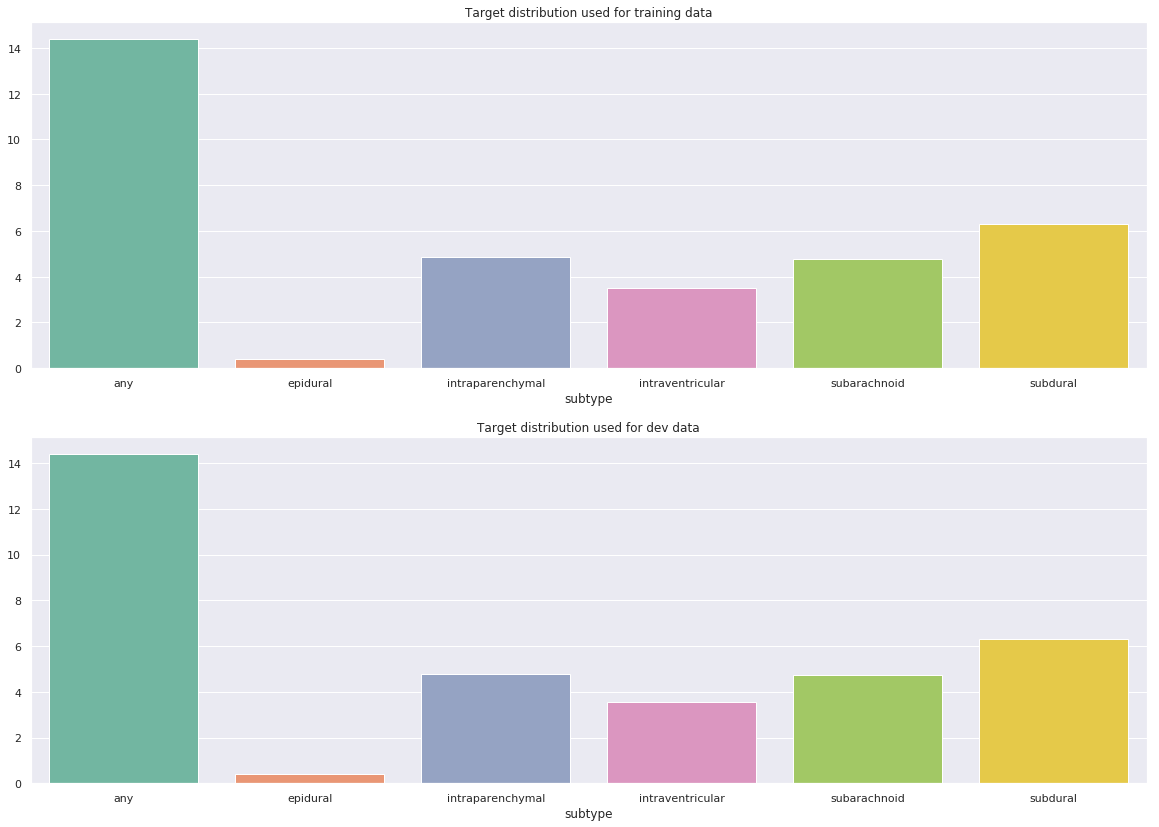

In [20]:
pos_perc_train = train_data.sum() / train_data.shape[0] * 100
pos_perc_dev = dev_data.sum() / dev_data.shape[0] * 100

fig, ax = plt.subplots(2,1,figsize=(20,14))
sns.barplot(x=pos_perc_train.index, y=pos_perc_train.values, palette="Set2", ax=ax[0]);
ax[0].set_title("Target distribution used for training data")
sns.barplot(x=pos_perc_dev.index, y=pos_perc_dev.values, palette="Set2", ax=ax[1]);
ax[1].set_title("Target distribution used for dev data");

## Loss functions

By writing this kernel I'm going to play with different loss functions. 


### Multilabel loss

The first one is just a simple binary cross entropy per class summed up. We can use tensorflows sigmoid_cross_entropy for this purpose as it assumes mutually exclusive targets for this task. The weights $w_{s}$ can be used to set more importance to specific classes like the any-part in the brute force approach that contributes more to the evaluation loss.

$$L = - \frac{1}{N} \sum_{n=1}^{N} \sum_{s=1}^{S} w_{s} \cdot [t_{n,s} \cdot \ln(y_{n,s}) + (1-t_{n,s}) \cdot \ln(1-y_{n,s})] $$  

### Multilabel Focal loss

To tackle the class imbalance we could also introduce class weights for each multilabel class:

$$l_{n,s} = \alpha_{s} \cdot t_{n,s} \cdot \ln(y_{n,s}) + (1-\alpha_{s}) \cdot (1-t_{n,s}) \cdot \ln(1-y_{n,s}) $$  

Furthermore we could also try to improve by using a [focal loss ](https://arxiv.org/abs/1708.02002)per multilabel class:

$$ L = - \frac{1}{N} \sum_{n=1}^{N} \sum_{s=1}^{S} w_{s} \cdot [(1-\alpha) \cdot (1-y_{n,s})^{\gamma} \cdot t_{n,s} \cdot  \ln(y_{n,s}) + \alpha \cdot y_{n,s}^{\gamma} \cdot (1-t_{n,s}) \cdot \ln(1-y_{n,s})]$$

$$ L = -\frac{1}{N} \sum_{n=1}^{N} \sum_{s=1}^{S} w_{s} \cdot [(1-\alpha_{t})(1-y_{n,s,t})^{\gamma} \cdot \ln(y_{n,s,t})] $$

With $\gamma$ between 0 and 5. With $\gamma=0$ we have no effect but with increasing its value we enforce higher contributions to the loss for misclassified samples whereas the contributions for already well classified samples are down-weighted. 


In [21]:
def np_multilabel_loss(y_true, y_pred, class_weights=None):
    y_pred = np.where(y_pred > 1-(1e-07), 1-1e-07, y_pred)
    y_pred = np.where(y_pred < 1e-07, 1e-07, y_pred)
    single_class_cross_entropies = - np.mean(y_true * np.log(y_pred) + (1-y_true) * np.log(1-y_pred), axis=0)
    
    print(single_class_cross_entropies)
    if class_weights is None:
        loss = np.mean(single_class_cross_entropies)
    else:
        loss = np.sum(class_weights*single_class_cross_entropies)
    return loss

def get_raw_xentropies(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
    xentropies = y_true * tf.log(y_pred) + (1-y_true) * tf.log(1-y_pred)
    return -xentropies

# multilabel focal loss equals multilabel loss in case of alpha=0.5 and gamma=0 
def multilabel_focal_loss(class_weights=None, alpha=0.5, gamma=2):
    def mutlilabel_focal_loss_inner(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        xentropies = get_raw_xentropies(y_true, y_pred)

        # compute pred_t:
        y_t = tf.where(tf.equal(y_true,1), y_pred, 1.-y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha * tf.ones_like(y_true), (1-alpha) * tf.ones_like(y_true))

        # compute focal loss contributions
        focal_loss_contributions =  tf.multiply(tf.multiply(tf.pow(1-y_t, gamma), xentropies), alpha_t) 

        # our focal loss contributions have shape (n_samples, s_classes), we need to reduce with mean over samples:
        focal_loss_per_class = tf.reduce_mean(focal_loss_contributions, axis=0)

        # compute the overall loss if class weights are None (equally weighted):
        if class_weights is None:
            focal_loss_result = tf.reduce_mean(focal_loss_per_class)
        else:
            # weight the single class losses and compute the overall loss
            weights = tf.constant(class_weights, dtype=tf.float32)
            focal_loss_result = tf.reduce_sum(tf.multiply(weights, focal_loss_per_class))
            
        return focal_loss_result
    return mutlilabel_focal_loss_inner

## Let it run! :-)

In [22]:
BACKBONE = "resnet_50"
BATCH_SIZE = 16
TEST_BATCH_SIZE = 5
MIN_VALUE = 0
MAX_VALUE = 90
STEPS = 50
EPOCHS = 20

LR = 0.0001

In [23]:
train_preprocessor = Preprocessor(path=train_dir,
                                  backbone=pretrained_models[BACKBONE],
                                  hu_min_value=MIN_VALUE,
                                  hu_max_value=MAX_VALUE,
                                  augment=True)

dev_preprocessor = Preprocessor(path=train_dir,
                                backbone=pretrained_models[BACKBONE],
                                hu_min_value=MIN_VALUE,
                                hu_max_value=MAX_VALUE,
                                augment=False)

test_preprocessor = Preprocessor(path=test_dir,
                                backbone=pretrained_models[BACKBONE],
                                hu_min_value=MIN_VALUE,
                                hu_max_value=MAX_VALUE,
                                augment=False)

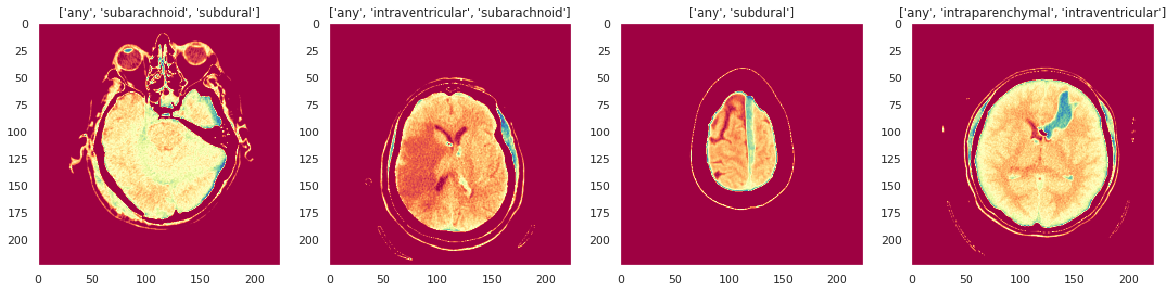

In [24]:
fig, ax = plt.subplots(1,4,figsize=(20,20))


for m in range(4):
    example = train_data.index.values[m]
    title = [col for col in train_data.loc[example,:].index if train_data.loc[example, col]==1]
    if len(title) == 0:
        title="Healthy"
    preprocess_example = train_preprocessor.preprocess(example)
    ax[m].imshow(preprocess_example[:,:,2], cmap="Spectral")
    ax[m].grid(False)
    ax[m].set_title(title);

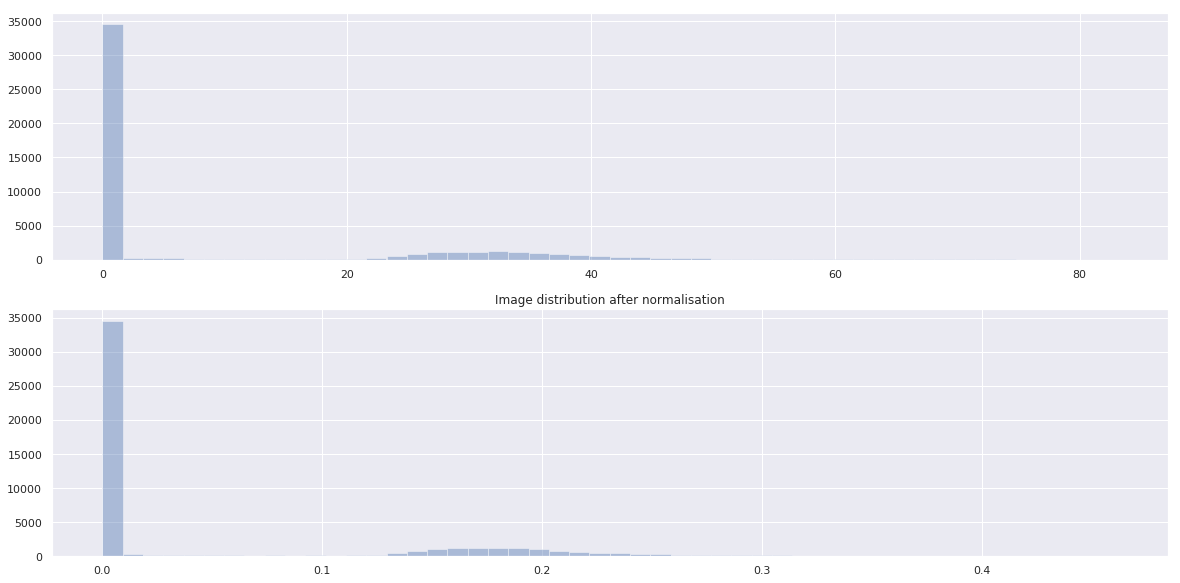

In [25]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
sns.distplot(preprocess_example[:,:,2].flatten(), kde=False, ax=ax[0])
sns.distplot(train_preprocessor.normalize(preprocess_example)[:,:,2].flatten(), kde=False)
plt.title("Image distribution after normalisation");

In [26]:
train_preprocessor.normalize(preprocess_example[:,:,2]).min()

0.0

In [27]:
train_preprocessor.normalize(preprocess_example[:,:,2]).max()

0.46143834006085505

In [28]:
train_dataloader = DataLoader(train_data,
                              train_preprocessor,
                              BATCH_SIZE,
                              shuffle=True,
                              steps=STEPS)

dev_dataloader = DataLoader(dev_data, 
                            dev_preprocessor,
                            BATCH_SIZE,
                            shuffle=True,
                            steps=STEPS)

test_dataloader = DataLoader(testdf, 
                             test_preprocessor,
                             TEST_BATCH_SIZE,
                             shuffle=False)

In [29]:
train_dataloader.__len__()

51

In [30]:
len(train_dataloader.data_ids)/BATCH_SIZE

51.0

In [31]:
train_data.loc[train_dataloader.data_ids]["any"].value_counts()

0    544
1    272
Name: any, dtype: int64

In [32]:
test_dataloader.__len__()

15709

In [33]:
dev_dataloader.__len__()

51

In [34]:
my_class_weights = [0.5, 0.1, 0.1, 0.1, 0.1, 0.1]

In [35]:
def turn_pred_to_dataframe(data_df, pred):
    df = pd.DataFrame(pred, columns=data_df.columns, index=data_df.index)
    df = df.stack().reset_index()
    df.loc[:, "ID"] = df.id.str.cat(df.subtype, sep="_")
    df = df.drop(["id", "subtype"], axis=1)
    df = df.rename({0: "Label"}, axis=1)
    return df

In [36]:
if train_brute_force:
    model = MyNetwork(model_fun=resnet_50,
                      loss_fun="binary_crossentropy", #multilabel_focal_loss(class_weights=my_class_weights, alpha=0.5, gamma=0),
                      metrics_list=[multilabel_focal_loss(alpha=0.5, gamma=0)],
                      train_generator=train_dataloader,
                      dev_generator=dev_dataloader,
                      epochs=EPOCHS,
                      num_classes=6)
    model.build_model()
    model.compile_model()
    history = model.learn()
    
    print(history.history.keys())
    
    fig, ax = plt.subplots(2,1,figsize=(20,5))
    ax[0].plot(history.history["loss"], 'o-')
    ax[0].plot(history.history["val_loss"], 'o-')
    ax[1].plot(history.history["lr"], 'o-')
    
    #test_pred = model.predict(test_dataloader)[0:testdf.shape[0]]
    #dev_pred = model.predict(dev_dataloader)
    
    #test_pred_df = turn_pred_to_dataframe(testdf, test_pred)
    #dev_pred_df = turn_pred_to_dataframe(dev_data, dev_pred)
    
    #test_pred_df.to_csv("brute_force_test_pred.csv", index=False)
    #dev_pred_df.to_csv("brute_force_dev_pred.csv", index=False)

In [37]:
dev_proba = model.predict(dev_dataloader)
dev_proba.shape

NameError: name 'model' is not defined

In [38]:
plt.figure(figsize=(20,5))
for n in range(6):
    sns.distplot(dev_proba[:,n])

NameError: name 'dev_proba' is not defined

<Figure size 1440x360 with 0 Axes>

# Building up the any-subtype network

## The custom loss <a class="anchor" id="customloss"></a>

In my opinion the first important part is to reconstruct the **weighted multilabel logarithmic loss**. I have already touched it a bit during the [evaluation part](#evaluation) in the beginning of this kernel:

$$l_{n,s} = t_{n,s} \cdot \ln(y_{n,s}) + (1-t_{n,s}) \cdot \ln(1-y_{n,s}) $$  

Then they seem to be added, whereas the any-subtype obtains a higher weight than the others:

$$ l_{n} = \sum_{s} w_{s} \cdot l_{n,s} $$

And finally this loss is averaged over all samples:

$$ Loss = -\frac{1}{N} \cdot \sum_{n} l_{n} $$

But there was one part I haven't mentioned: **The any part depends on the subtype decisions. In contrast we can assume that the subtypes themselves are independent from each other to make the problem simpler**. Hence if you have epidural hemorrhage this might not mean that there is a higher probability of intraparenchymal as well. By assuming independece we can decouple the subtypes and use the binary xentropy loss as described above. But this does not include the any-part. In this case we need to take care of the dependence of any (A) and subtype (S) and could write:

$$P(A,S) = P(A) \cdot P(S|A) = P(S) \cdot P(A|S) $$

Consequently we could either let the network answer the questions: 
* Do you have any hemorrhage? And dependent on this answer we could make subtype decisions. 
* Or we could do it the other way round: Do you have subtype s? And dependent on the answers of each subtype - is there any kind of hemorrhage?

**I feel more comfortable with the first way**. Answering the any-part shows lower class imbalance than all the others (no wonders). By yielding a better fit for this part, we have additional fruitful information (the probability of any) to answer the second more difficutl part of the subtypes which shows very high class imbalance. Would love to discuss about it. If you like, let me know if you find this important or not in the comments.

## A two output layer network <a class="anchor" id="twooutputs"></a>

To realize the idea of making the subtype decision based on the any-decision, we need to rework a bit the network architecture:

* We need an output for the any decision based on one layer (i) of our choice.
* We need an output for the subtype decision that is based on the layer (i) **and** the output of the any-decision.

Let's extend our MyNetwork class. This way we can switch between brute force approach (decouple all targets) and our "keep any-subtype dependence"-approach: 

In [39]:
alpha_subtypes = 0.25 
gamma_subtypes = 2

In [40]:
class AnySubtypeNetwork(MyNetwork):
    
    def __init__(self,
                 model_fun,
                 loss_fun,
                 metrics_list,
                 train_generator,
                 dev_generator,
                 epochs,
                 num_subtype_classes=5,
                 checkpoint_path=MODELOUTPUT_PATH_ANYSUBTYPE):
        MyNetwork.__init__(self, 
                           model_fun=model_fun,
                           loss_fun=loss_fun,
                           metrics_list=metrics_list,
                           train_generator=train_generator,
                           dev_generator=dev_generator,
                           epochs=epochs,
                           num_classes=num_subtype_classes)
    
    def build_model(self):
        base_model = self.model_fun()
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)
        any_logits = Dense(1, kernel_initializer=he_normal(seed=11))(x)
        any_pred = Activation("sigmoid", name="any_predictions")(any_logits)
        x = concatenate([any_pred, x])
        sub_pred = Dense(self.num_classes,
                         name="subtype_pred",
                         kernel_initializer=he_normal(seed=12),
                         activation="sigmoid")(x) 
        self.model = Model(inputs=base_model.input, outputs=[any_pred, sub_pred])
    
    def compile_model(self):
        self.model.compile(optimizer=Adam(LR),
                           loss=['binary_crossentropy', multilabel_focal_loss(alpha=alpha_subtypes, gamma=gamma_subtypes)],
                           loss_weights = [1., 0.],
                           metrics=self.metrics_list)

Now you can see that the any loss and the subtype loss are weighted the same. Doing so the any-part has comparable higher weight than any of the single subtypes. This is still a simplification. We don't know it neither for the any nor for single subtypes. **But we have taken the first advice "weight any higher" into account**.

## Multioutput DataLoader <a class="anchor" id="twooutputsdataloader"></a>

In [41]:
class AnySubtypeDataLoader(Sequence):
    
    def __init__(self, dataframe,
                 preprocessor,
                 batch_size,
                 num_classes=5,
                 shuffle=False,
                 steps=None):
        self.preprocessor = preprocessor
        self.data_ids = dataframe.index.values
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.input_shape = self.preprocessor.backbone["nn_input_shape"]
        self.preprocess_fun = self.preprocessor.backbone["preprocess_fun"]
        self.num_classes = num_classes
        self.current_epoch=0
        
        self.steps=steps
        if self.steps is not None:
            self.steps = np.round(self.steps/2) * 2
            self.undersample()
        
    def undersample(self):
        part = np.int(self.steps/2 * self.batch_size)
        zero_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 0].index.values, size=1*part, replace=False)
        hot_ids = np.random.choice(self.dataframe.loc[self.dataframe["any"] == 1].index.values, size=1*part, replace=False)
        self.data_ids = list(set(zero_ids).union(hot_ids))
        np.random.shuffle(self.data_ids)
    
    # defines the number of steps per epoch
    def __len__(self):
        if self.steps is None:
            return np.int(np.ceil(len(self.data_ids) / np.float(self.batch_size)))
        else:
            return 2*np.int(self.steps/2) 
    
    # at the end of an epoch: 
    def on_epoch_end(self):
        # if steps is None and shuffle is true:
        if self.steps is None:
            self.data_ids = self.dataframe.index.values
            if self.shuffle:
                np.random.shuffle(self.data_ids)
        else:
            self.undersample()
        self.current_epoch += 1
    
    # should return a batch of images
    def __getitem__(self, item):
        # select the ids of the current batch
        current_ids = self.data_ids[item*self.batch_size:(item+1)*self.batch_size]
        X, y_any, y_subtype = self.__generate_batch(current_ids)
        return X, [y_any, y_subtype]
    
    # collect the preprocessed images and targets of one batch
    def __generate_batch(self, current_ids):
        X = np.empty((self.batch_size, *self.input_shape, 3))
        y_subtype = np.empty((self.batch_size, self.num_classes))
        y_any = np.empty((self.batch_size, 1))
        for idx, ident in enumerate(current_ids):
            # Store sample
            image = self.preprocessor.preprocess(ident)
            X[idx] = self.preprocessor.normalize(image)
            # Store class
            y_any[idx], y_subtype[idx] = self.__get_target(ident)
        return X, y_any, y_subtype
    
    # extract the targets of one image id:
    def __get_target(self, ident):
        y_any = self.dataframe.loc[ident, "any"]
        y_subtype = self.dataframe.drop("any", axis=1).loc[ident].values
        return y_any, y_subtype

In [42]:
train_dataloader = AnySubtypeDataLoader(train_data,
                                        train_preprocessor,
                                        BATCH_SIZE,
                                        steps=STEPS)
dev_dataloader = AnySubtypeDataLoader(dev_data, 
                                      dev_preprocessor,
                                      BATCH_SIZE,
                                      steps=STEPS,
                                      shuffle=False)

test_dataloader = AnySubtypeDataLoader(testdf, 
                                       test_preprocessor,
                                       TEST_BATCH_SIZE,
                                       shuffle=False)

In [43]:
X, [y1, y2] = train_dataloader.__getitem__(0)

In [44]:
y1.shape

(16, 1)

In [45]:
y2.shape

(16, 5)

In [46]:
X.shape

(16, 224, 224, 3)

In [47]:
y1[0]

array([0.])

In [48]:
y2[0]

array([0., 0., 0., 0., 0.])

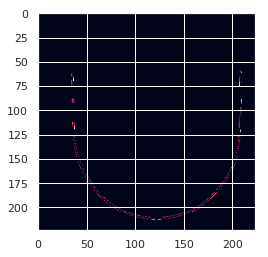

In [49]:
plt.imshow(X[0,:,:,0])

In [50]:
train_dataloader.__len__()

50

In [51]:
len(train_dataloader.data_ids)

800

In [52]:
train_data.loc[train_dataloader.data_ids].sum() / train_data.loc[train_dataloader.data_ids].shape[0]

subtype
any                 0.50000
epidural            0.01125
intraparenchymal    0.17000
intraventricular    0.13250
subarachnoid        0.15375
subdural            0.18875
dtype: float64

In [53]:
if train_anysubtype_network:
    model = AnySubtypeNetwork(model_fun=resnet_50,
                              loss_fun=None,
                              metrics_list={"any_predictions":"binary_crossentropy",
                                            "subtype_pred": multilabel_focal_loss(alpha=0.5, gamma=0)},
                              train_generator=train_dataloader,
                              dev_generator=dev_dataloader,
                              epochs=50) 
    model.build_model()
    model.compile_model()
    history = model.learn()
    
    print(history.history.keys())
    
    fig, ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].plot(history.history["loss"], 'o-')
    ax[0].plot(history.history["val_loss"], 'o-')
    ax[1].plot(history.history["lr"], 'o-')
else:
    model = AnySubtypeNetwork(model_fun=resnet_50,
                              loss_fun=None,
                              metrics_list={"any_predictions":"binary_crossentropy",
                                            "subtype_pred": multilabel_focal_loss(alpha=0.5, gamma=0)},
                              train_generator=train_dataloader,
                              dev_generator=dev_dataloader,
                              epochs=50) 
    model.build_model()
    #model.load_weights(any_subtype_model_input)

In [54]:
dev_proba_any, dev_proba_subtype = model.predict(dev_dataloader)

In [55]:
train_proba_any, train_proba_subtype = model.predict(train_dataloader)

In [56]:
dev_proba_any.shape

(800, 1)

In [57]:
dev_proba_subtype.shape

(800, 5)

In [58]:
if train_anysubtype_network:
    fig, ax = plt.subplots(2,1, figsize=(20,10))
    sns.distplot(dev_proba_any[:,0], ax=ax[0], color="Purple")
    sns.distplot(dev_proba_subtype[:,0], ax=ax[1])
    sns.distplot(dev_proba_subtype[:,1], ax=ax[1])
    sns.distplot(dev_proba_subtype[:,2], ax=ax[1])
    sns.distplot(dev_proba_subtype[:,3], ax=ax[1])
    sns.distplot(dev_proba_subtype[:,4], ax=ax[1])
    ax[0].set_title("Predicted probability of hemorrhage occurence in dev batch")
    ax[1].set_title("Predicted probability of hemorrhage subtypes in dev batch")
    
    fig, ax = plt.subplots(2,1, figsize=(20,10))
    sns.distplot(train_proba_any[:,0], ax=ax[0], color="Purple")
    sns.distplot(train_proba_subtype[:,0], ax=ax[1])
    sns.distplot(train_proba_subtype[:,1], ax=ax[1])
    sns.distplot(train_proba_subtype[:,2], ax=ax[1])
    sns.distplot(train_proba_subtype[:,3], ax=ax[1])
    sns.distplot(train_proba_subtype[:,4], ax=ax[1])
    ax[0].set_title("Predicted probability of hemorrhage occurence in train")
    ax[1].set_title("Predicted probability of hemorrhage subtypes in train")